# <center>MobileNet - Pytorch

# Step 1: Prepare data

In [1]:
# MobileNet-Pytorch
import argparse 
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score
#from mobilenets import mobilenet

use_cuda = torch.cuda.is_available()
use_cudause_cud  = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [2]:
# Train, Validate, Test. Heavily inspired by Kevinzakka https://github.com/kevinzakka/DenseNet/blob/master/data_loader.py

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

valid_size=0.1

# define transforms
valid_transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
])

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])


# load the dataset
train_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=train_transform)

valid_dataset = datasets.CIFAR10(root="data", train=True, 
            download=True, transform=valid_transform)

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(valid_size * num_train)) #5w张图片的10%用来当做验证集


np.random.seed(42)# 42
np.random.shuffle(indices) # 随机乱序[0,1,...,49999]

train_idx, valid_idx = indices[split:], indices[:split]


train_sampler = SubsetRandomSampler(train_idx) # 这个很有意思
valid_sampler = SubsetRandomSampler(valid_idx)

###################################################################################
# ------------------------- 使用不同的批次大小 ------------------------------------
###################################################################################

show_step=2  # 批次大，show_step就小点
max_epoch=80  # 训练最大epoch数目

train_loader = torch.utils.data.DataLoader(train_dataset, 
                batch_size=256, sampler=train_sampler)

valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                batch_size=256, sampler=valid_sampler)


test_transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

test_dataset = datasets.CIFAR10(root="data", 
                                train=False, 
                                download=True,transform=test_transform)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=256, 
                                          shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


# Step 2: Model Config

# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 3
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs,out_channel,in_Channel]
        w = self.conv1D(w)
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
        # -------------- softmax ---------------------------
        #print(w.shape)
        w = w.view(w.shape[0],w.shape[1],w.shape[2],1,1)
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
        out=out.view(out.shape[0],1,out.shape[1],out.shape[2],out.shape[3])
        #print("x size:",out.shape)
        
        out=out*w
        #print("after fusion x size:",out.shape)
        out=out.sum(dim=2)
        
        out = F.relu(self.bn2(out))
        
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]

    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            out_planes = x if isinstance(x, int) else x[0]
            stride = 1 if isinstance(x, int) else x[1]
            layers.append(Block(in_planes, out_planes, stride))
            in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [3]:
# 32  缩放5次到 1x1@1024 
# From https://github.com/kuangliu/pytorch-cifar 
import torch
import torch.nn as nn
import torch.nn.functional as F

class Block_Attention_HALF(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention_HALF, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        #------------------------ 一半 ------------------------------
        self.conv2 = nn.Conv2d(in_planes, int(out_planes*0.125), kernel_size=1, stride=1, padding=0, bias=True)
        
        #------------------------ 另一半 ----------------------------
        self.scaleLayer= nn.Conv1d(1, 1, 1, stride=1,padding=0,groups=1,dilation=1,bias=True)
        
        one_conv_kernel_size = 13 # [3,7,9]
        self.conv1D= nn.Conv1d(1, int(out_planes*0.875), one_conv_kernel_size, stride=1,padding=6,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        #------------------------------------------------------------
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu6(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        #w=w[0]-torch.mean(w[0])
        w=w[0]
        #w=torch.randn(w[0].shape).cuda()*1
        
        a=torch.randn(1).cuda()*0.1
        if a>0.37:
            print(w.shape)
            print(w)
        
        w=w.view(1,1,in_channel)
        
        w=self.scaleLayer(w)  #自动缩放层
        
        if a>0.37:
            print(self.scaleLayer.weight)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        
        #-------------------------------------
        w = 0.1*F.tanh(w) # [-0.5,+0.5]
        #w=F.softmax(w,dim=2)
        
        if a>0.37:
            print(self.conv1D.weight.shape)
            print(self.conv1D.weight)
            print(w.shape)
            print(w)
            
        # [bs=1,out_channel//2,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel//2,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out_1=self.conv2(out)
        out_2=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)
        out=torch.cat([out_1,out_2],1)
        
        # ----------------------- 试一试不要用relu -------------------------------
        out = F.relu6(self.bn2(out))
        
        return out

class Block_Attention(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block_Attention, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        
        #self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        one_conv_kernel_size = 17 # [3,7,9]
        self.conv1D= nn.Conv1d(1, out_planes, one_conv_kernel_size, stride=1,padding=8,groups=1,dilation=1,bias=False) # 在__init__初始化        
        
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        
        out = F.relu(self.bn1(self.conv1(x)))
        
        # -------------------------- Attention -----------------------
        w = F.avg_pool2d(x,x.shape[-1])  #最好在初始化层定义好
        #print(w.shape)
        # [bs,in_Channel,1,1]
        in_channel=w.shape[1]
        #w = w.view(w.shape[0],1,w.shape[1])
        # [bs,1,in_Channel]
        # 对这批数据取平均 且保留第0维
        
        #w= w.mean(dim=0,keepdim=True)
        
        
#         MAX=w.shape[0]
#         NUM=torch.floor(MAX*torch.rand(1)).long()
#         if NUM>=0 and NUM<MAX:
#             w=w[NUM]
#         else:
#             w=w[0]
        
        w=w[0]
        
        w=w.view(1,1,in_channel)
        # [bs=1,1,in_Channel]
        # one_conv_filter = nn.Conv1d(1, out_channel, one_conv_kernel_size, stride=1,padding=1,groups=1,dilation=1) # 在__init__初始化
        # [bs=1,out_channel,in_Channel]
        w = self.conv1D(w)
        # [bs=1,out_channel,in_Channel]
        w = 0.5*F.tanh(w) # [-0.5,+0.5]
         # [bs=1,out_channel,in_Channel]
        w=w.view(w.shape[1],w.shape[2],1,1)
        # [out_channel,in_Channel,1,1]
        
        # -------------- softmax ---------------------------
        #print(w.shape)
        
        # ------------------------- fusion --------------------------
       
        # conv 1x1
        out=F.conv2d(out,w,bias=None,stride=1,groups=1,dilation=1)

        out = F.relu(self.bn2(out))
        
        return out


class Block(nn.Module):
    '''Depthwise conv + Pointwise conv'''
    def __init__(self, in_planes, out_planes, stride=1):
        super(Block, self).__init__()
        
        # 分组卷积数=输入通道数
        self.conv1 = nn.Conv2d(in_planes, in_planes, kernel_size=3, stride=stride, padding=1, groups=in_planes, bias=False)
        
        self.bn1 = nn.BatchNorm2d(in_planes)
        
        self.conv2 = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        
        self.bn2 = nn.BatchNorm2d(out_planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out


class MobileNet(nn.Module):
    # (128,2) means conv planes=128, conv stride=2, by default conv stride=1
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), 1024]
    
    #cfg = [64, (128,2), 128, (256,2), 256, (512,2), 512, 512, 512, 512, 512, (1024,2), [1024,1]]
    cfg = [64, (128,2), 128, 256, 256, (512,2), 512, [512,1], [512,1],[512,1], [512,1], [1024,1], [1024,1]]
    
    def __init__(self, num_classes=10):
        super(MobileNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32) # 自动化构建层
        self.linear = nn.Linear(1024, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for x in self.cfg:
            if isinstance(x, int):
                out_planes = x
                stride = 1 
                layers.append(Block(in_planes, out_planes, stride))
            elif isinstance(x, tuple):
                out_planes = x[0]
                stride = x[1]
                layers.append(Block(in_planes, out_planes, stride))
            # AC层通过list存放设置参数
            elif isinstance(x, list):
                out_planes= x[0]
                stride = x[1] if len(x)==2 else 1
                layers.append(Block_Attention_HALF(in_planes, out_planes, stride))   
            else:
                pass
            
            in_planes = out_planes
            
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [4]:
# From https://github.com/Z0m6ie/CIFAR-10_PyTorch
#model = mobilenet(num_classes=10, large_img=False)

# From https://github.com/kuangliu/pytorch-cifar 
if torch.cuda.is_available():
    model=MobileNet(10).cuda()
else:
    model=MobileNet(10)

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
#scheduler = StepLR(optimizer, step_size=70, gamma=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[50,70,75,80], gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [5]:
# Implement validation
def train(epoch):
    model.train()
    #writer = SummaryWriter()
    for batch_idx, (data, target) in enumerate(train_loader):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        correct = 0
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()
        
        loss = criterion(output, target)
        loss.backward()
        accuracy = 100. * (correct.cpu().numpy()/ len(output))
        optimizer.step()
        if batch_idx % 5*show_step == 0:
#             if batch_idx % 2*show_step == 0:
#                 print(model.layers[1].conv1D.weight.shape)
#                 print(model.layers[1].conv1D.weight[0:2][0:2])
            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1=open("Cifar10_INFO.txt","a+")
#             f1.write("\n"+'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.2f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item(), accuracy))
#             f1.close()
            
            #writer.add_scalar('Loss/Loss', loss.item(), epoch)
            #writer.add_scalar('Accuracy/Accuracy', accuracy, epoch)
    scheduler.step()

In [6]:
def validate(epoch):
    model.eval()
    #writer = SummaryWriter()
    valid_loss = 0
    correct = 0
    for data, target in valid_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        valid_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).sum()

    valid_loss /= len(valid_idx)
    accuracy = 100. * correct.cpu().numpy() / len(valid_idx)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        valid_loss, correct, len(valid_idx),
        100. * correct / len(valid_idx)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         valid_loss, correct, len(valid_idx),
#         100. * correct / len(valid_idx)))
#     f1.close()
    #writer.add_scalar('Loss/Validation_Loss', valid_loss, epoch)
    #writer.add_scalar('Accuracy/Validation_Accuracy', accuracy, epoch)
    return valid_loss, accuracy

In [7]:
# Fix best model

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        output = model(data)
        test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct.cpu().numpy() / len(test_loader.dataset)))
    
#     f1=open("Cifar10_INFO.txt","a+")
#     f1.write('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct.cpu().numpy() / len(test_loader.dataset)))
#     f1.close()

In [8]:
def save_best(loss, accuracy, best_loss, best_acc):
    if best_loss == None:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
        
    elif loss < best_loss and accuracy > best_acc:
        best_loss = loss
        best_acc = accuracy
        file = 'saved_models/best_save_model.p'
        torch.save(model.state_dict(), file)
    return best_loss, best_acc

In [9]:
# Fantastic logger for tensorboard and pytorch, 
# run tensorboard by opening a new terminal and run "tensorboard --logdir runs"
# open tensorboard at http://localhost:6006/
from tensorboardX import SummaryWriter
best_loss = None
best_acc = None

import time 
SINCE=time.time()

for epoch in range(max_epoch):
    train(epoch)
    
    loss, accuracy = validate(epoch)
    best_loss, best_acc = save_best(loss, accuracy, best_loss, best_acc)
    
    NOW=time.time() 
    DURINGS=NOW-SINCE
    SINCE=NOW
    print("the time of this epoch:[{} s]".format(DURINGS))
    
    if epoch>=10 and (epoch-10)%2==0:
        test(epoch)
    
# writer = SummaryWriter() 
# writer.export_scalars_to_json("./all_scalars.json")

# writer.close()

#---------------------------- Test ------------------------------
test(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 2.329112, Accuracy: 10.55
Train Epoch: 0 [1280/50000 (3%)]	Loss: 2.331939, Accuracy: 8.98
Train Epoch: 0 [2560/50000 (6%)]	Loss: 2.269483, Accuracy: 10.55
Train Epoch: 0 [3840/50000 (9%)]	Loss: 2.255202, Accuracy: 17.19
Train Epoch: 0 [5120/50000 (11%)]	Loss: 2.152086, Accuracy: 17.19
Train Epoch: 0 [6400/50000 (14%)]	Loss: 2.175110, Accuracy: 18.75
Train Epoch: 0 [7680/50000 (17%)]	Loss: 2.101811, Accuracy: 15.62
Train Epoch: 0 [8960/50000 (20%)]	Loss: 2.050855, Accuracy: 17.97
Train Epoch: 0 [10240/50000 (23%)]	Loss: 2.075396, Accuracy: 19.53
Train Epoch: 0 [11520/50000 (26%)]	Loss: 1.996977, Accuracy: 20.70
Train Epoch: 0 [12800/50000 (28%)]	Loss: 1.976524, Accuracy: 17.97
Train Epoch: 0 [14080/50000 (31%)]	Loss: 2.044901, Accuracy: 17.58
Train Epoch: 0 [15360/50000 (34%)]	Loss: 1.945777, Accuracy: 22.27
Train Epoch: 0 [16640/50000 (37%)]	Loss: 1.980004, Accuracy: 22.27
Train Epoch: 0 [17920/50000 (40%)]	Loss: 2.005622, Accuracy: 23.83
Train Epoch

Train Epoch: 2 [10240/50000 (23%)]	Loss: 1.323240, Accuracy: 52.34
Train Epoch: 2 [11520/50000 (26%)]	Loss: 1.404346, Accuracy: 48.05
Train Epoch: 2 [12800/50000 (28%)]	Loss: 1.379467, Accuracy: 55.47
Train Epoch: 2 [14080/50000 (31%)]	Loss: 1.322758, Accuracy: 51.17
Train Epoch: 2 [15360/50000 (34%)]	Loss: 1.404650, Accuracy: 52.73
Train Epoch: 2 [16640/50000 (37%)]	Loss: 1.344853, Accuracy: 50.78
Train Epoch: 2 [17920/50000 (40%)]	Loss: 1.416520, Accuracy: 47.27
Train Epoch: 2 [19200/50000 (43%)]	Loss: 1.414035, Accuracy: 46.48
Train Epoch: 2 [20480/50000 (45%)]	Loss: 1.358327, Accuracy: 49.61
Train Epoch: 2 [21760/50000 (48%)]	Loss: 1.324537, Accuracy: 46.88
Train Epoch: 2 [23040/50000 (51%)]	Loss: 1.318148, Accuracy: 52.34
Train Epoch: 2 [24320/50000 (54%)]	Loss: 1.380993, Accuracy: 48.83
Train Epoch: 2 [25600/50000 (57%)]	Loss: 1.386579, Accuracy: 45.70
Train Epoch: 2 [26880/50000 (60%)]	Loss: 1.271506, Accuracy: 53.12
Train Epoch: 2 [28160/50000 (62%)]	Loss: 1.274311, Accuracy: 5

Train Epoch: 3 [2560/50000 (6%)]	Loss: 1.166486, Accuracy: 58.59
Train Epoch: 3 [3840/50000 (9%)]	Loss: 1.158385, Accuracy: 57.03
Train Epoch: 3 [5120/50000 (11%)]	Loss: 1.210713, Accuracy: 58.98
Train Epoch: 3 [6400/50000 (14%)]	Loss: 1.298489, Accuracy: 55.47
Train Epoch: 3 [7680/50000 (17%)]	Loss: 1.207046, Accuracy: 57.81
Train Epoch: 3 [8960/50000 (20%)]	Loss: 1.108949, Accuracy: 58.98
Train Epoch: 3 [10240/50000 (23%)]	Loss: 1.102285, Accuracy: 61.72
Train Epoch: 3 [11520/50000 (26%)]	Loss: 1.292103, Accuracy: 55.08
Train Epoch: 3 [12800/50000 (28%)]	Loss: 1.062541, Accuracy: 64.45
Train Epoch: 3 [14080/50000 (31%)]	Loss: 1.119843, Accuracy: 58.59
Train Epoch: 3 [15360/50000 (34%)]	Loss: 1.233345, Accuracy: 55.86
Train Epoch: 3 [16640/50000 (37%)]	Loss: 0.993727, Accuracy: 64.45
Train Epoch: 3 [17920/50000 (40%)]	Loss: 1.189023, Accuracy: 57.03
Train Epoch: 3 [19200/50000 (43%)]	Loss: 1.121965, Accuracy: 57.42
Train Epoch: 3 [20480/50000 (45%)]	Loss: 1.221964, Accuracy: 57.03
Tra

Train Epoch: 4 [26880/50000 (60%)]	Loss: 0.857586, Accuracy: 65.62
Train Epoch: 4 [28160/50000 (62%)]	Loss: 1.008799, Accuracy: 63.28
Train Epoch: 4 [29440/50000 (65%)]	Loss: 0.935740, Accuracy: 66.41
Train Epoch: 4 [30720/50000 (68%)]	Loss: 1.015284, Accuracy: 64.45
Train Epoch: 4 [32000/50000 (71%)]	Loss: 0.948221, Accuracy: 68.75
Train Epoch: 4 [33280/50000 (74%)]	Loss: 0.984640, Accuracy: 66.02
Train Epoch: 4 [34560/50000 (77%)]	Loss: 0.933013, Accuracy: 67.97
Train Epoch: 4 [35840/50000 (80%)]	Loss: 0.910831, Accuracy: 68.36
Train Epoch: 4 [37120/50000 (82%)]	Loss: 0.946458, Accuracy: 66.02
Train Epoch: 4 [38400/50000 (85%)]	Loss: 0.791995, Accuracy: 74.22
Train Epoch: 4 [39680/50000 (88%)]	Loss: 0.836429, Accuracy: 75.00
Train Epoch: 4 [40960/50000 (91%)]	Loss: 0.960835, Accuracy: 64.06
Train Epoch: 4 [42240/50000 (94%)]	Loss: 0.899545, Accuracy: 68.36
Train Epoch: 4 [43520/50000 (97%)]	Loss: 0.968692, Accuracy: 68.36
Train Epoch: 4 [35000/50000 (99%)]	Loss: 0.915120, Accuracy: 7

Train Epoch: 7 [39680/50000 (88%)]	Loss: 0.725222, Accuracy: 75.00
Train Epoch: 7 [40960/50000 (91%)]	Loss: 0.728713, Accuracy: 75.00
Train Epoch: 7 [42240/50000 (94%)]	Loss: 0.602114, Accuracy: 81.64
Train Epoch: 7 [43520/50000 (97%)]	Loss: 0.700164, Accuracy: 77.34
Train Epoch: 7 [35000/50000 (99%)]	Loss: 0.767010, Accuracy: 76.00

Validation set: Average loss: 0.9946, Accuracy: 3366/5000 (67.00%)

the time of this epoch:[37.81495451927185 s]
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.630426, Accuracy: 78.91
Train Epoch: 8 [1280/50000 (3%)]	Loss: 0.732682, Accuracy: 73.05
Train Epoch: 8 [2560/50000 (6%)]	Loss: 0.546613, Accuracy: 82.42
Train Epoch: 8 [3840/50000 (9%)]	Loss: 0.566824, Accuracy: 77.73
Train Epoch: 8 [5120/50000 (11%)]	Loss: 0.643367, Accuracy: 78.91
Train Epoch: 8 [6400/50000 (14%)]	Loss: 0.601966, Accuracy: 78.52
Train Epoch: 8 [7680/50000 (17%)]	Loss: 0.583344, Accuracy: 76.56
Train Epoch: 8 [8960/50000 (20%)]	Loss: 0.800645, Accuracy: 72.66
Train Epoch: 8 [10240/50000 (2

Train Epoch: 9 [12800/50000 (28%)]	Loss: 0.588500, Accuracy: 81.25
Train Epoch: 9 [14080/50000 (31%)]	Loss: 0.617249, Accuracy: 79.30
Train Epoch: 9 [15360/50000 (34%)]	Loss: 0.614006, Accuracy: 80.08
Train Epoch: 9 [16640/50000 (37%)]	Loss: 0.569773, Accuracy: 82.42
Train Epoch: 9 [17920/50000 (40%)]	Loss: 0.543308, Accuracy: 80.47
Train Epoch: 9 [19200/50000 (43%)]	Loss: 0.592120, Accuracy: 80.86
Train Epoch: 9 [20480/50000 (45%)]	Loss: 0.630556, Accuracy: 76.95
Train Epoch: 9 [21760/50000 (48%)]	Loss: 0.601600, Accuracy: 79.30
Train Epoch: 9 [23040/50000 (51%)]	Loss: 0.533292, Accuracy: 81.25
Train Epoch: 9 [24320/50000 (54%)]	Loss: 0.601883, Accuracy: 78.12
Train Epoch: 9 [25600/50000 (57%)]	Loss: 0.655627, Accuracy: 77.73
Train Epoch: 9 [26880/50000 (60%)]	Loss: 0.604590, Accuracy: 78.52
Train Epoch: 9 [28160/50000 (62%)]	Loss: 0.631581, Accuracy: 78.12
Train Epoch: 9 [29440/50000 (65%)]	Loss: 0.631826, Accuracy: 78.91
Train Epoch: 9 [30720/50000 (68%)]	Loss: 0.623317, Accuracy: 8

Train Epoch: 12 [23040/50000 (51%)]	Loss: 0.519777, Accuracy: 82.03
Train Epoch: 12 [24320/50000 (54%)]	Loss: 0.521879, Accuracy: 81.25
Train Epoch: 12 [25600/50000 (57%)]	Loss: 0.499494, Accuracy: 83.98
Train Epoch: 12 [26880/50000 (60%)]	Loss: 0.460083, Accuracy: 85.55
Train Epoch: 12 [28160/50000 (62%)]	Loss: 0.604296, Accuracy: 78.12
Train Epoch: 12 [29440/50000 (65%)]	Loss: 0.650593, Accuracy: 80.08
Train Epoch: 12 [30720/50000 (68%)]	Loss: 0.484433, Accuracy: 84.38
Train Epoch: 12 [32000/50000 (71%)]	Loss: 0.522679, Accuracy: 84.77
Train Epoch: 12 [33280/50000 (74%)]	Loss: 0.448516, Accuracy: 84.77
Train Epoch: 12 [34560/50000 (77%)]	Loss: 0.596749, Accuracy: 80.08
Train Epoch: 12 [35840/50000 (80%)]	Loss: 0.540413, Accuracy: 81.25
Train Epoch: 12 [37120/50000 (82%)]	Loss: 0.577040, Accuracy: 77.34
Train Epoch: 12 [38400/50000 (85%)]	Loss: 0.615830, Accuracy: 79.69
Train Epoch: 12 [39680/50000 (88%)]	Loss: 0.431170, Accuracy: 85.16
Train Epoch: 12 [40960/50000 (91%)]	Loss: 0.5964

Train Epoch: 15 [32000/50000 (71%)]	Loss: 0.417776, Accuracy: 83.59
Train Epoch: 15 [33280/50000 (74%)]	Loss: 0.423125, Accuracy: 85.16
Train Epoch: 15 [34560/50000 (77%)]	Loss: 0.516814, Accuracy: 83.59
Train Epoch: 15 [35840/50000 (80%)]	Loss: 0.603676, Accuracy: 80.08
Train Epoch: 15 [37120/50000 (82%)]	Loss: 0.484484, Accuracy: 82.81
Train Epoch: 15 [38400/50000 (85%)]	Loss: 0.430166, Accuracy: 85.94
Train Epoch: 15 [39680/50000 (88%)]	Loss: 0.481169, Accuracy: 83.98
Train Epoch: 15 [40960/50000 (91%)]	Loss: 0.448453, Accuracy: 86.33
Train Epoch: 15 [42240/50000 (94%)]	Loss: 0.536660, Accuracy: 83.59
Train Epoch: 15 [43520/50000 (97%)]	Loss: 0.561242, Accuracy: 82.03
Train Epoch: 15 [35000/50000 (99%)]	Loss: 0.485575, Accuracy: 85.00

Validation set: Average loss: 0.7601, Accuracy: 3805/5000 (76.00%)

the time of this epoch:[41.00613451004028 s]
Train Epoch: 16 [0/50000 (0%)]	Loss: 0.416676, Accuracy: 86.72
Train Epoch: 16 [1280/50000 (3%)]	Loss: 0.417915, Accuracy: 86.72
Train Epo

Train Epoch: 18 [42240/50000 (94%)]	Loss: 0.453429, Accuracy: 82.81
Train Epoch: 18 [43520/50000 (97%)]	Loss: 0.524916, Accuracy: 81.25
Train Epoch: 18 [35000/50000 (99%)]	Loss: 0.422331, Accuracy: 87.00

Validation set: Average loss: 0.6301, Accuracy: 3942/5000 (78.00%)

the time of this epoch:[37.87766480445862 s]

Test set: Average loss: 0.6601, Accuracy: 7788/10000 (77.88%)

Train Epoch: 19 [0/50000 (0%)]	Loss: 0.429320, Accuracy: 85.55
Train Epoch: 19 [1280/50000 (3%)]	Loss: 0.468809, Accuracy: 83.20
Train Epoch: 19 [2560/50000 (6%)]	Loss: 0.555179, Accuracy: 82.42
Train Epoch: 19 [3840/50000 (9%)]	Loss: 0.370538, Accuracy: 89.06
Train Epoch: 19 [5120/50000 (11%)]	Loss: 0.451959, Accuracy: 84.38
Train Epoch: 19 [6400/50000 (14%)]	Loss: 0.394976, Accuracy: 85.94
Train Epoch: 19 [7680/50000 (17%)]	Loss: 0.460754, Accuracy: 84.38
Train Epoch: 19 [8960/50000 (20%)]	Loss: 0.425294, Accuracy: 85.55
Train Epoch: 19 [10240/50000 (23%)]	Loss: 0.385480, Accuracy: 85.94
Train Epoch: 19 [1152

Train Epoch: 22 [2560/50000 (6%)]	Loss: 0.436366, Accuracy: 86.33
Train Epoch: 22 [3840/50000 (9%)]	Loss: 0.430877, Accuracy: 83.98
Train Epoch: 22 [5120/50000 (11%)]	Loss: 0.312550, Accuracy: 88.28
Train Epoch: 22 [6400/50000 (14%)]	Loss: 0.477294, Accuracy: 84.38
Train Epoch: 22 [7680/50000 (17%)]	Loss: 0.435417, Accuracy: 85.94
Train Epoch: 22 [8960/50000 (20%)]	Loss: 0.438722, Accuracy: 86.72
Train Epoch: 22 [10240/50000 (23%)]	Loss: 0.535277, Accuracy: 86.33
Train Epoch: 22 [11520/50000 (26%)]	Loss: 0.496989, Accuracy: 83.20
Train Epoch: 22 [12800/50000 (28%)]	Loss: 0.451695, Accuracy: 87.11
Train Epoch: 22 [14080/50000 (31%)]	Loss: 0.473109, Accuracy: 83.59
Train Epoch: 22 [15360/50000 (34%)]	Loss: 0.412281, Accuracy: 85.16
Train Epoch: 22 [16640/50000 (37%)]	Loss: 0.462456, Accuracy: 86.33
Train Epoch: 22 [17920/50000 (40%)]	Loss: 0.331487, Accuracy: 88.28
Train Epoch: 22 [19200/50000 (43%)]	Loss: 0.545769, Accuracy: 82.42
Train Epoch: 22 [20480/50000 (45%)]	Loss: 0.490031, Accu

Train Epoch: 25 [11520/50000 (26%)]	Loss: 0.419424, Accuracy: 86.33
Train Epoch: 25 [12800/50000 (28%)]	Loss: 0.512115, Accuracy: 82.03
Train Epoch: 25 [14080/50000 (31%)]	Loss: 0.455962, Accuracy: 82.81
Train Epoch: 25 [15360/50000 (34%)]	Loss: 0.408195, Accuracy: 85.94
Train Epoch: 25 [16640/50000 (37%)]	Loss: 0.473434, Accuracy: 84.38
Train Epoch: 25 [17920/50000 (40%)]	Loss: 0.408133, Accuracy: 87.50
Train Epoch: 25 [19200/50000 (43%)]	Loss: 0.365833, Accuracy: 87.89
Train Epoch: 25 [20480/50000 (45%)]	Loss: 0.444146, Accuracy: 85.94
Train Epoch: 25 [21760/50000 (48%)]	Loss: 0.466606, Accuracy: 83.59
Train Epoch: 25 [23040/50000 (51%)]	Loss: 0.415174, Accuracy: 85.16
Train Epoch: 25 [24320/50000 (54%)]	Loss: 0.412840, Accuracy: 84.38
Train Epoch: 25 [25600/50000 (57%)]	Loss: 0.470307, Accuracy: 84.38
Train Epoch: 25 [26880/50000 (60%)]	Loss: 0.432900, Accuracy: 83.98
Train Epoch: 25 [28160/50000 (62%)]	Loss: 0.403374, Accuracy: 87.50
Train Epoch: 25 [29440/50000 (65%)]	Loss: 0.4659

Train Epoch: 28 [21760/50000 (48%)]	Loss: 0.412190, Accuracy: 86.72
Train Epoch: 28 [23040/50000 (51%)]	Loss: 0.389039, Accuracy: 86.33
Train Epoch: 28 [24320/50000 (54%)]	Loss: 0.424749, Accuracy: 86.72
Train Epoch: 28 [25600/50000 (57%)]	Loss: 0.435146, Accuracy: 86.33
Train Epoch: 28 [26880/50000 (60%)]	Loss: 0.432342, Accuracy: 86.33
Train Epoch: 28 [28160/50000 (62%)]	Loss: 0.491350, Accuracy: 83.20
Train Epoch: 28 [29440/50000 (65%)]	Loss: 0.398932, Accuracy: 87.11
Train Epoch: 28 [30720/50000 (68%)]	Loss: 0.470973, Accuracy: 83.20
Train Epoch: 28 [32000/50000 (71%)]	Loss: 0.438170, Accuracy: 83.98
Train Epoch: 28 [33280/50000 (74%)]	Loss: 0.374023, Accuracy: 86.72
Train Epoch: 28 [34560/50000 (77%)]	Loss: 0.359260, Accuracy: 87.50
Train Epoch: 28 [35840/50000 (80%)]	Loss: 0.367135, Accuracy: 87.50
Train Epoch: 28 [37120/50000 (82%)]	Loss: 0.480883, Accuracy: 82.81
Train Epoch: 28 [38400/50000 (85%)]	Loss: 0.360678, Accuracy: 86.33
Train Epoch: 28 [39680/50000 (88%)]	Loss: 0.4315

Train Epoch: 31 [30720/50000 (68%)]	Loss: 0.445071, Accuracy: 83.59
Train Epoch: 31 [32000/50000 (71%)]	Loss: 0.442206, Accuracy: 84.38
Train Epoch: 31 [33280/50000 (74%)]	Loss: 0.360281, Accuracy: 85.16
Train Epoch: 31 [34560/50000 (77%)]	Loss: 0.373220, Accuracy: 86.33
Train Epoch: 31 [35840/50000 (80%)]	Loss: 0.326877, Accuracy: 90.62
Train Epoch: 31 [37120/50000 (82%)]	Loss: 0.295791, Accuracy: 89.06
Train Epoch: 31 [38400/50000 (85%)]	Loss: 0.462912, Accuracy: 86.72
Train Epoch: 31 [39680/50000 (88%)]	Loss: 0.412932, Accuracy: 86.33
Train Epoch: 31 [40960/50000 (91%)]	Loss: 0.346409, Accuracy: 88.67
Train Epoch: 31 [42240/50000 (94%)]	Loss: 0.442931, Accuracy: 83.59
Train Epoch: 31 [43520/50000 (97%)]	Loss: 0.461277, Accuracy: 82.03
Train Epoch: 31 [35000/50000 (99%)]	Loss: 0.536782, Accuracy: 84.00

Validation set: Average loss: 0.5921, Accuracy: 3988/5000 (79.00%)

the time of this epoch:[40.910672187805176 s]
Train Epoch: 32 [0/50000 (0%)]	Loss: 0.321166, Accuracy: 90.23
Train 

Train Epoch: 34 [40960/50000 (91%)]	Loss: 0.446214, Accuracy: 86.33
Train Epoch: 34 [42240/50000 (94%)]	Loss: 0.341663, Accuracy: 87.50
Train Epoch: 34 [43520/50000 (97%)]	Loss: 0.387499, Accuracy: 85.94
Train Epoch: 34 [35000/50000 (99%)]	Loss: 0.387970, Accuracy: 86.00

Validation set: Average loss: 0.7461, Accuracy: 3779/5000 (75.00%)

the time of this epoch:[37.681721925735474 s]

Test set: Average loss: 0.7722, Accuracy: 7495/10000 (74.95%)

Train Epoch: 35 [0/50000 (0%)]	Loss: 0.385906, Accuracy: 85.55
Train Epoch: 35 [1280/50000 (3%)]	Loss: 0.340975, Accuracy: 86.72
Train Epoch: 35 [2560/50000 (6%)]	Loss: 0.355732, Accuracy: 89.84
Train Epoch: 35 [3840/50000 (9%)]	Loss: 0.385215, Accuracy: 87.89
Train Epoch: 35 [5120/50000 (11%)]	Loss: 0.374375, Accuracy: 87.50
Train Epoch: 35 [6400/50000 (14%)]	Loss: 0.356995, Accuracy: 86.72
Train Epoch: 35 [7680/50000 (17%)]	Loss: 0.347757, Accuracy: 87.50
Train Epoch: 35 [8960/50000 (20%)]	Loss: 0.391565, Accuracy: 86.72
Train Epoch: 35 [102

Train Epoch: 36 [40960/50000 (91%)]	Loss: 0.418225, Accuracy: 86.33
Train Epoch: 36 [42240/50000 (94%)]	Loss: 0.323748, Accuracy: 89.06
Train Epoch: 36 [43520/50000 (97%)]	Loss: 0.333089, Accuracy: 87.50
Train Epoch: 36 [35000/50000 (99%)]	Loss: 0.419230, Accuracy: 86.00

Validation set: Average loss: 0.5907, Accuracy: 4008/5000 (80.00%)

the time of this epoch:[37.688355684280396 s]

Test set: Average loss: 0.6083, Accuracy: 7982/10000 (79.82%)

Train Epoch: 37 [0/50000 (0%)]	Loss: 0.378109, Accuracy: 86.72
Train Epoch: 37 [1280/50000 (3%)]	Loss: 0.316631, Accuracy: 90.23
Train Epoch: 37 [2560/50000 (6%)]	Loss: 0.368457, Accuracy: 88.67
Train Epoch: 37 [3840/50000 (9%)]	Loss: 0.444406, Accuracy: 85.55
Train Epoch: 37 [5120/50000 (11%)]	Loss: 0.472705, Accuracy: 80.86
Train Epoch: 37 [6400/50000 (14%)]	Loss: 0.482735, Accuracy: 82.81
Train Epoch: 37 [7680/50000 (17%)]	Loss: 0.411793, Accuracy: 85.55
Train Epoch: 37 [8960/50000 (20%)]	Loss: 0.476794, Accuracy: 83.59
Train Epoch: 37 [102

Train Epoch: 40 [1280/50000 (3%)]	Loss: 0.302167, Accuracy: 90.62
Train Epoch: 40 [2560/50000 (6%)]	Loss: 0.430871, Accuracy: 88.28
Train Epoch: 40 [3840/50000 (9%)]	Loss: 0.413056, Accuracy: 84.38
Train Epoch: 40 [5120/50000 (11%)]	Loss: 0.302301, Accuracy: 88.28
Train Epoch: 40 [6400/50000 (14%)]	Loss: 0.376794, Accuracy: 89.45
Train Epoch: 40 [7680/50000 (17%)]	Loss: 0.358910, Accuracy: 85.16
Train Epoch: 40 [8960/50000 (20%)]	Loss: 0.354233, Accuracy: 87.11
Train Epoch: 40 [10240/50000 (23%)]	Loss: 0.439632, Accuracy: 83.98
Train Epoch: 40 [11520/50000 (26%)]	Loss: 0.242870, Accuracy: 92.58
Train Epoch: 40 [12800/50000 (28%)]	Loss: 0.339692, Accuracy: 87.50
Train Epoch: 40 [14080/50000 (31%)]	Loss: 0.388117, Accuracy: 86.72
Train Epoch: 40 [15360/50000 (34%)]	Loss: 0.447051, Accuracy: 85.55
Train Epoch: 40 [16640/50000 (37%)]	Loss: 0.382162, Accuracy: 87.50
Train Epoch: 40 [17920/50000 (40%)]	Loss: 0.395624, Accuracy: 85.55
Train Epoch: 40 [19200/50000 (43%)]	Loss: 0.333206, Accura

Train Epoch: 43 [10240/50000 (23%)]	Loss: 0.313768, Accuracy: 89.84
Train Epoch: 43 [11520/50000 (26%)]	Loss: 0.364052, Accuracy: 89.06
Train Epoch: 43 [12800/50000 (28%)]	Loss: 0.349397, Accuracy: 86.72
Train Epoch: 43 [14080/50000 (31%)]	Loss: 0.290933, Accuracy: 91.41
Train Epoch: 43 [15360/50000 (34%)]	Loss: 0.315711, Accuracy: 88.28
Train Epoch: 43 [16640/50000 (37%)]	Loss: 0.386867, Accuracy: 86.72
Train Epoch: 43 [17920/50000 (40%)]	Loss: 0.339686, Accuracy: 87.89
Train Epoch: 43 [19200/50000 (43%)]	Loss: 0.443950, Accuracy: 83.98
Train Epoch: 43 [20480/50000 (45%)]	Loss: 0.389626, Accuracy: 88.28
Train Epoch: 43 [21760/50000 (48%)]	Loss: 0.470288, Accuracy: 83.98
Train Epoch: 43 [23040/50000 (51%)]	Loss: 0.376949, Accuracy: 87.11
Train Epoch: 43 [24320/50000 (54%)]	Loss: 0.340871, Accuracy: 89.45
Train Epoch: 43 [25600/50000 (57%)]	Loss: 0.386807, Accuracy: 88.28
Train Epoch: 43 [26880/50000 (60%)]	Loss: 0.345890, Accuracy: 88.28
Train Epoch: 43 [28160/50000 (62%)]	Loss: 0.3291

Train Epoch: 46 [20480/50000 (45%)]	Loss: 0.346731, Accuracy: 87.11
Train Epoch: 46 [21760/50000 (48%)]	Loss: 0.358525, Accuracy: 88.67
Train Epoch: 46 [23040/50000 (51%)]	Loss: 0.273283, Accuracy: 91.41
Train Epoch: 46 [24320/50000 (54%)]	Loss: 0.340715, Accuracy: 88.28
Train Epoch: 46 [25600/50000 (57%)]	Loss: 0.334041, Accuracy: 89.84
Train Epoch: 46 [26880/50000 (60%)]	Loss: 0.420720, Accuracy: 84.77
Train Epoch: 46 [28160/50000 (62%)]	Loss: 0.376696, Accuracy: 87.11
Train Epoch: 46 [29440/50000 (65%)]	Loss: 0.369283, Accuracy: 86.72
Train Epoch: 46 [30720/50000 (68%)]	Loss: 0.453044, Accuracy: 85.55
Train Epoch: 46 [32000/50000 (71%)]	Loss: 0.382484, Accuracy: 89.45
Train Epoch: 46 [33280/50000 (74%)]	Loss: 0.429405, Accuracy: 82.42
Train Epoch: 46 [34560/50000 (77%)]	Loss: 0.395682, Accuracy: 87.11
Train Epoch: 46 [35840/50000 (80%)]	Loss: 0.425256, Accuracy: 86.33
Train Epoch: 46 [37120/50000 (82%)]	Loss: 0.296044, Accuracy: 87.89
Train Epoch: 46 [38400/50000 (85%)]	Loss: 0.4568

Train Epoch: 48 [3840/50000 (9%)]	Loss: 0.426536, Accuracy: 85.55
Train Epoch: 48 [5120/50000 (11%)]	Loss: 0.286717, Accuracy: 91.80
Train Epoch: 48 [6400/50000 (14%)]	Loss: 0.379401, Accuracy: 87.89
Train Epoch: 48 [7680/50000 (17%)]	Loss: 0.378148, Accuracy: 88.28
Train Epoch: 48 [8960/50000 (20%)]	Loss: 0.308394, Accuracy: 90.23
Train Epoch: 48 [10240/50000 (23%)]	Loss: 0.418849, Accuracy: 85.94
Train Epoch: 48 [11520/50000 (26%)]	Loss: 0.394378, Accuracy: 87.11
Train Epoch: 48 [12800/50000 (28%)]	Loss: 0.393830, Accuracy: 86.72
Train Epoch: 48 [14080/50000 (31%)]	Loss: 0.303740, Accuracy: 91.41
Train Epoch: 48 [15360/50000 (34%)]	Loss: 0.393903, Accuracy: 87.11
Train Epoch: 48 [16640/50000 (37%)]	Loss: 0.350420, Accuracy: 87.11
Train Epoch: 48 [17920/50000 (40%)]	Loss: 0.285813, Accuracy: 91.02
Train Epoch: 48 [19200/50000 (43%)]	Loss: 0.389188, Accuracy: 86.72
Train Epoch: 48 [20480/50000 (45%)]	Loss: 0.505334, Accuracy: 80.08
Train Epoch: 48 [21760/50000 (48%)]	Loss: 0.450127, Ac

Train Epoch: 51 [12800/50000 (28%)]	Loss: 0.288771, Accuracy: 91.02
Train Epoch: 51 [14080/50000 (31%)]	Loss: 0.246238, Accuracy: 92.19
Train Epoch: 51 [15360/50000 (34%)]	Loss: 0.220288, Accuracy: 92.19
Train Epoch: 51 [16640/50000 (37%)]	Loss: 0.199961, Accuracy: 94.53
Train Epoch: 51 [17920/50000 (40%)]	Loss: 0.219229, Accuracy: 91.80
Train Epoch: 51 [19200/50000 (43%)]	Loss: 0.234061, Accuracy: 92.19
Train Epoch: 51 [20480/50000 (45%)]	Loss: 0.252298, Accuracy: 90.62
Train Epoch: 51 [21760/50000 (48%)]	Loss: 0.201405, Accuracy: 92.58
Train Epoch: 51 [23040/50000 (51%)]	Loss: 0.267991, Accuracy: 91.41
Train Epoch: 51 [24320/50000 (54%)]	Loss: 0.238909, Accuracy: 90.23
Train Epoch: 51 [25600/50000 (57%)]	Loss: 0.180892, Accuracy: 94.92
Train Epoch: 51 [26880/50000 (60%)]	Loss: 0.200866, Accuracy: 94.14
Train Epoch: 51 [28160/50000 (62%)]	Loss: 0.266211, Accuracy: 91.02
Train Epoch: 51 [29440/50000 (65%)]	Loss: 0.200898, Accuracy: 94.53
Train Epoch: 51 [30720/50000 (68%)]	Loss: 0.2717

Train Epoch: 54 [23040/50000 (51%)]	Loss: 0.182113, Accuracy: 94.53
Train Epoch: 54 [24320/50000 (54%)]	Loss: 0.159936, Accuracy: 93.75
Train Epoch: 54 [25600/50000 (57%)]	Loss: 0.187109, Accuracy: 96.09
Train Epoch: 54 [26880/50000 (60%)]	Loss: 0.160292, Accuracy: 94.14
Train Epoch: 54 [28160/50000 (62%)]	Loss: 0.135391, Accuracy: 94.92
Train Epoch: 54 [29440/50000 (65%)]	Loss: 0.202805, Accuracy: 93.75
Train Epoch: 54 [30720/50000 (68%)]	Loss: 0.132051, Accuracy: 96.48
Train Epoch: 54 [32000/50000 (71%)]	Loss: 0.135034, Accuracy: 96.48
Train Epoch: 54 [33280/50000 (74%)]	Loss: 0.239380, Accuracy: 91.80
Train Epoch: 54 [34560/50000 (77%)]	Loss: 0.159273, Accuracy: 94.92
Train Epoch: 54 [35840/50000 (80%)]	Loss: 0.131234, Accuracy: 94.92
Train Epoch: 54 [37120/50000 (82%)]	Loss: 0.120807, Accuracy: 95.70
Train Epoch: 54 [38400/50000 (85%)]	Loss: 0.140794, Accuracy: 94.92
Train Epoch: 54 [39680/50000 (88%)]	Loss: 0.163518, Accuracy: 93.75
Train Epoch: 54 [40960/50000 (91%)]	Loss: 0.1587

Train Epoch: 57 [6400/50000 (14%)]	Loss: 0.126439, Accuracy: 96.48
Train Epoch: 57 [7680/50000 (17%)]	Loss: 0.130849, Accuracy: 95.70
Train Epoch: 57 [8960/50000 (20%)]	Loss: 0.089782, Accuracy: 96.88
Train Epoch: 57 [10240/50000 (23%)]	Loss: 0.104704, Accuracy: 96.09
Train Epoch: 57 [11520/50000 (26%)]	Loss: 0.133179, Accuracy: 94.53
Train Epoch: 57 [12800/50000 (28%)]	Loss: 0.140492, Accuracy: 94.92
Train Epoch: 57 [14080/50000 (31%)]	Loss: 0.093499, Accuracy: 97.66
Train Epoch: 57 [15360/50000 (34%)]	Loss: 0.159256, Accuracy: 94.53
Train Epoch: 57 [16640/50000 (37%)]	Loss: 0.175418, Accuracy: 92.97
Train Epoch: 57 [17920/50000 (40%)]	Loss: 0.092608, Accuracy: 97.27
Train Epoch: 57 [19200/50000 (43%)]	Loss: 0.101113, Accuracy: 96.09
Train Epoch: 57 [20480/50000 (45%)]	Loss: 0.121153, Accuracy: 95.31
Train Epoch: 57 [21760/50000 (48%)]	Loss: 0.210125, Accuracy: 93.36
Train Epoch: 57 [23040/50000 (51%)]	Loss: 0.138941, Accuracy: 96.09
Train Epoch: 57 [24320/50000 (54%)]	Loss: 0.105716,

Train Epoch: 58 [24320/50000 (54%)]	Loss: 0.113918, Accuracy: 95.70
Train Epoch: 58 [25600/50000 (57%)]	Loss: 0.154254, Accuracy: 95.70
Train Epoch: 58 [26880/50000 (60%)]	Loss: 0.070233, Accuracy: 98.05
Train Epoch: 58 [28160/50000 (62%)]	Loss: 0.087972, Accuracy: 96.88
Train Epoch: 58 [29440/50000 (65%)]	Loss: 0.125038, Accuracy: 94.53
Train Epoch: 58 [30720/50000 (68%)]	Loss: 0.153229, Accuracy: 95.70
Train Epoch: 58 [32000/50000 (71%)]	Loss: 0.125467, Accuracy: 96.88
Train Epoch: 58 [33280/50000 (74%)]	Loss: 0.129481, Accuracy: 96.09
Train Epoch: 58 [34560/50000 (77%)]	Loss: 0.111650, Accuracy: 96.88
Train Epoch: 58 [35840/50000 (80%)]	Loss: 0.140033, Accuracy: 95.31
Train Epoch: 58 [37120/50000 (82%)]	Loss: 0.153795, Accuracy: 94.92
Train Epoch: 58 [38400/50000 (85%)]	Loss: 0.123279, Accuracy: 94.53
Train Epoch: 58 [39680/50000 (88%)]	Loss: 0.147017, Accuracy: 93.36
Train Epoch: 58 [40960/50000 (91%)]	Loss: 0.124560, Accuracy: 96.88
Train Epoch: 58 [42240/50000 (94%)]	Loss: 0.1011

Train Epoch: 59 [21760/50000 (48%)]	Loss: 0.093969, Accuracy: 96.48
Train Epoch: 59 [23040/50000 (51%)]	Loss: 0.116493, Accuracy: 96.09
Train Epoch: 59 [24320/50000 (54%)]	Loss: 0.102543, Accuracy: 96.48
Train Epoch: 59 [25600/50000 (57%)]	Loss: 0.148017, Accuracy: 94.53
Train Epoch: 59 [26880/50000 (60%)]	Loss: 0.117158, Accuracy: 97.27
Train Epoch: 59 [28160/50000 (62%)]	Loss: 0.143834, Accuracy: 94.92
Train Epoch: 59 [29440/50000 (65%)]	Loss: 0.108776, Accuracy: 96.09
Train Epoch: 59 [30720/50000 (68%)]	Loss: 0.137692, Accuracy: 94.14
Train Epoch: 59 [32000/50000 (71%)]	Loss: 0.112453, Accuracy: 96.09
Train Epoch: 59 [33280/50000 (74%)]	Loss: 0.132241, Accuracy: 95.31
Train Epoch: 59 [34560/50000 (77%)]	Loss: 0.131001, Accuracy: 94.92
Train Epoch: 59 [35840/50000 (80%)]	Loss: 0.111947, Accuracy: 96.48
Train Epoch: 59 [37120/50000 (82%)]	Loss: 0.102416, Accuracy: 95.70
Train Epoch: 59 [38400/50000 (85%)]	Loss: 0.151575, Accuracy: 95.70
Train Epoch: 59 [39680/50000 (88%)]	Loss: 0.0797

Train Epoch: 62 [32000/50000 (71%)]	Loss: 0.079459, Accuracy: 97.27
Train Epoch: 62 [33280/50000 (74%)]	Loss: 0.091486, Accuracy: 98.05
Train Epoch: 62 [34560/50000 (77%)]	Loss: 0.059580, Accuracy: 97.66
Train Epoch: 62 [35840/50000 (80%)]	Loss: 0.096972, Accuracy: 96.88
Train Epoch: 62 [37120/50000 (82%)]	Loss: 0.082366, Accuracy: 97.66
Train Epoch: 62 [38400/50000 (85%)]	Loss: 0.128664, Accuracy: 94.53
Train Epoch: 62 [39680/50000 (88%)]	Loss: 0.112904, Accuracy: 96.48
Train Epoch: 62 [40960/50000 (91%)]	Loss: 0.108268, Accuracy: 95.70
Train Epoch: 62 [42240/50000 (94%)]	Loss: 0.111764, Accuracy: 97.27
Train Epoch: 62 [43520/50000 (97%)]	Loss: 0.072846, Accuracy: 98.05
Train Epoch: 62 [35000/50000 (99%)]	Loss: 0.105960, Accuracy: 96.00

Validation set: Average loss: 0.2698, Accuracy: 4595/5000 (91.00%)

the time of this epoch:[37.710078954696655 s]

Test set: Average loss: 0.3085, Accuracy: 9074/10000 (90.74%)

Train Epoch: 63 [0/50000 (0%)]	Loss: 0.055899, Accuracy: 98.44
Train Epoc

Train Epoch: 65 [14080/50000 (31%)]	Loss: 0.084718, Accuracy: 97.66
Train Epoch: 65 [15360/50000 (34%)]	Loss: 0.119498, Accuracy: 96.48
Train Epoch: 65 [16640/50000 (37%)]	Loss: 0.082104, Accuracy: 97.27
Train Epoch: 65 [17920/50000 (40%)]	Loss: 0.079552, Accuracy: 96.88
Train Epoch: 65 [19200/50000 (43%)]	Loss: 0.066711, Accuracy: 97.27
Train Epoch: 65 [20480/50000 (45%)]	Loss: 0.096923, Accuracy: 96.09
Train Epoch: 65 [21760/50000 (48%)]	Loss: 0.129154, Accuracy: 95.31
Train Epoch: 65 [23040/50000 (51%)]	Loss: 0.066255, Accuracy: 98.05
Train Epoch: 65 [24320/50000 (54%)]	Loss: 0.093871, Accuracy: 95.70
Train Epoch: 65 [25600/50000 (57%)]	Loss: 0.145346, Accuracy: 96.09
Train Epoch: 65 [26880/50000 (60%)]	Loss: 0.083097, Accuracy: 97.66
Train Epoch: 65 [28160/50000 (62%)]	Loss: 0.100034, Accuracy: 96.48
Train Epoch: 65 [29440/50000 (65%)]	Loss: 0.116556, Accuracy: 95.70
Train Epoch: 65 [30720/50000 (68%)]	Loss: 0.087993, Accuracy: 97.27
Train Epoch: 65 [32000/50000 (71%)]	Loss: 0.1099

Train Epoch: 68 [24320/50000 (54%)]	Loss: 0.122718, Accuracy: 96.48
Train Epoch: 68 [25600/50000 (57%)]	Loss: 0.080876, Accuracy: 96.88
Train Epoch: 68 [26880/50000 (60%)]	Loss: 0.080535, Accuracy: 96.88
Train Epoch: 68 [28160/50000 (62%)]	Loss: 0.101510, Accuracy: 96.09
Train Epoch: 68 [29440/50000 (65%)]	Loss: 0.068934, Accuracy: 97.27
Train Epoch: 68 [30720/50000 (68%)]	Loss: 0.085571, Accuracy: 96.88
Train Epoch: 68 [32000/50000 (71%)]	Loss: 0.102875, Accuracy: 96.88
Train Epoch: 68 [33280/50000 (74%)]	Loss: 0.065415, Accuracy: 98.44
Train Epoch: 68 [34560/50000 (77%)]	Loss: 0.054027, Accuracy: 98.83
Train Epoch: 68 [35840/50000 (80%)]	Loss: 0.039773, Accuracy: 98.44
Train Epoch: 68 [37120/50000 (82%)]	Loss: 0.074097, Accuracy: 97.66
Train Epoch: 68 [38400/50000 (85%)]	Loss: 0.097184, Accuracy: 95.70
Train Epoch: 68 [39680/50000 (88%)]	Loss: 0.145705, Accuracy: 95.70
Train Epoch: 68 [40960/50000 (91%)]	Loss: 0.066808, Accuracy: 98.05
Train Epoch: 68 [42240/50000 (94%)]	Loss: 0.0624

Train Epoch: 71 [5120/50000 (11%)]	Loss: 0.055259, Accuracy: 97.66
Train Epoch: 71 [6400/50000 (14%)]	Loss: 0.049084, Accuracy: 98.44
Train Epoch: 71 [7680/50000 (17%)]	Loss: 0.051555, Accuracy: 99.22
Train Epoch: 71 [8960/50000 (20%)]	Loss: 0.097704, Accuracy: 96.88
Train Epoch: 71 [10240/50000 (23%)]	Loss: 0.026434, Accuracy: 98.83
Train Epoch: 71 [11520/50000 (26%)]	Loss: 0.058796, Accuracy: 98.05
Train Epoch: 71 [12800/50000 (28%)]	Loss: 0.069214, Accuracy: 97.66
Train Epoch: 71 [14080/50000 (31%)]	Loss: 0.054145, Accuracy: 99.22
Train Epoch: 71 [15360/50000 (34%)]	Loss: 0.064576, Accuracy: 98.05
Train Epoch: 71 [16640/50000 (37%)]	Loss: 0.074546, Accuracy: 98.05
Train Epoch: 71 [17920/50000 (40%)]	Loss: 0.070738, Accuracy: 97.66
Train Epoch: 71 [19200/50000 (43%)]	Loss: 0.049052, Accuracy: 98.05
Train Epoch: 71 [20480/50000 (45%)]	Loss: 0.047183, Accuracy: 98.83
Train Epoch: 71 [21760/50000 (48%)]	Loss: 0.045071, Accuracy: 99.61
Train Epoch: 71 [23040/50000 (51%)]	Loss: 0.053411, 

Train Epoch: 74 [15360/50000 (34%)]	Loss: 0.094457, Accuracy: 96.09
Train Epoch: 74 [16640/50000 (37%)]	Loss: 0.045758, Accuracy: 98.05
Train Epoch: 74 [17920/50000 (40%)]	Loss: 0.080220, Accuracy: 97.27
Train Epoch: 74 [19200/50000 (43%)]	Loss: 0.056549, Accuracy: 98.83
Train Epoch: 74 [20480/50000 (45%)]	Loss: 0.049295, Accuracy: 99.22
Train Epoch: 74 [21760/50000 (48%)]	Loss: 0.075746, Accuracy: 97.27
Train Epoch: 74 [23040/50000 (51%)]	Loss: 0.048200, Accuracy: 98.05
Train Epoch: 74 [24320/50000 (54%)]	Loss: 0.037172, Accuracy: 98.83
Train Epoch: 74 [25600/50000 (57%)]	Loss: 0.055875, Accuracy: 98.05
Train Epoch: 74 [26880/50000 (60%)]	Loss: 0.025476, Accuracy: 99.22
Train Epoch: 74 [28160/50000 (62%)]	Loss: 0.063368, Accuracy: 96.88
Train Epoch: 74 [29440/50000 (65%)]	Loss: 0.059211, Accuracy: 98.05
Train Epoch: 74 [30720/50000 (68%)]	Loss: 0.076062, Accuracy: 97.27
Train Epoch: 74 [32000/50000 (71%)]	Loss: 0.096218, Accuracy: 97.27
Train Epoch: 74 [33280/50000 (74%)]	Loss: 0.0380


Test set: Average loss: 0.3249, Accuracy: 9126/10000 (91.26%)

Train Epoch: 77 [0/50000 (0%)]	Loss: 0.033818, Accuracy: 98.83
Train Epoch: 77 [1280/50000 (3%)]	Loss: 0.040264, Accuracy: 98.83
Train Epoch: 77 [2560/50000 (6%)]	Loss: 0.026574, Accuracy: 99.61
Train Epoch: 77 [3840/50000 (9%)]	Loss: 0.027768, Accuracy: 99.22
Train Epoch: 77 [5120/50000 (11%)]	Loss: 0.026647, Accuracy: 99.22
Train Epoch: 77 [6400/50000 (14%)]	Loss: 0.068554, Accuracy: 97.66
Train Epoch: 77 [7680/50000 (17%)]	Loss: 0.078147, Accuracy: 97.66
Train Epoch: 77 [8960/50000 (20%)]	Loss: 0.045335, Accuracy: 98.44
Train Epoch: 77 [10240/50000 (23%)]	Loss: 0.021985, Accuracy: 99.22
Train Epoch: 77 [11520/50000 (26%)]	Loss: 0.076191, Accuracy: 98.05
torch.Size([512, 1, 1])
tensor([[[ 0.1214]],

        [[ 0.0277]],

        [[ 0.0026]],

        [[ 0.0278]],

        [[ 0.0324]],

        [[ 0.0483]],

        [[ 0.0167]],

        [[ 0.0252]],

        [[ 0.0463]],

        [[ 0.0123]],

        [[ 0.0372]],

     

Train Epoch: 77 [14080/50000 (31%)]	Loss: 0.055759, Accuracy: 98.44
torch.Size([512, 1, 1])
tensor([[[ 0.0000]],

        [[ 0.1497]],

        [[ 0.0000]],

        [[ 0.0178]],

        [[ 0.0000]],

        [[ 0.1121]],

        [[ 0.0485]],

        [[ 0.0269]],

        [[ 0.0794]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0241]],

        [[ 0.0000]],

        [[ 0.0198]],

        [[ 0.0000]],

        [[ 0.0333]],

        [[ 0.0193]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.1048]],

        [[ 0.0000]],

        [[ 0.0371]],

        [[ 0.0004]],

        [[ 0.1798]],

        [[ 0.0000]],

        [[ 0.0502]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0339]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0000]],

        [[ 0.0233]],

        [[ 0.0000]],

        [[ 0.0407]],

        [[ 0.0000]],

        [[ 0.0174]],

        [[ 0.0000]],

        [[ 0.0531]],

        [[ 0.0000]],

      

Train Epoch: 77 [15360/50000 (34%)]	Loss: 0.043480, Accuracy: 98.44
Train Epoch: 77 [16640/50000 (37%)]	Loss: 0.034259, Accuracy: 98.83
Train Epoch: 77 [17920/50000 (40%)]	Loss: 0.039795, Accuracy: 98.83
Train Epoch: 77 [19200/50000 (43%)]	Loss: 0.038420, Accuracy: 97.66
Train Epoch: 77 [20480/50000 (45%)]	Loss: 0.062292, Accuracy: 97.66
Train Epoch: 77 [21760/50000 (48%)]	Loss: 0.044614, Accuracy: 98.83
Train Epoch: 77 [23040/50000 (51%)]	Loss: 0.055634, Accuracy: 98.44
Train Epoch: 77 [24320/50000 (54%)]	Loss: 0.048275, Accuracy: 98.83
Train Epoch: 77 [25600/50000 (57%)]	Loss: 0.029857, Accuracy: 99.22
Train Epoch: 77 [26880/50000 (60%)]	Loss: 0.042579, Accuracy: 98.05
Train Epoch: 77 [28160/50000 (62%)]	Loss: 0.056971, Accuracy: 98.83
Train Epoch: 77 [29440/50000 (65%)]	Loss: 0.039083, Accuracy: 98.44
Train Epoch: 77 [30720/50000 (68%)]	Loss: 0.069941, Accuracy: 97.66
Train Epoch: 77 [32000/50000 (71%)]	Loss: 0.042606, Accuracy: 98.83
Train Epoch: 77 [33280/50000 (74%)]	Loss: 0.0291

# Step 3: Test

In [10]:
test(epoch)


Test set: Average loss: 0.6902, Accuracy: 8877/10000 (88.77%)



## 第一次 scale 位于[0,1]

![](http://op4a94iq8.bkt.clouddn.com/18-7-14/70206949.jpg)

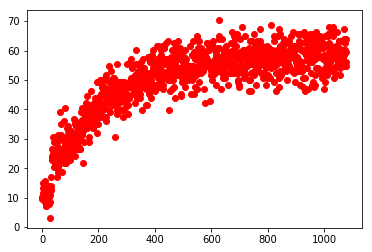

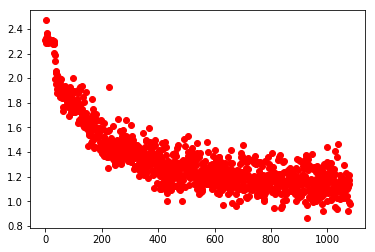

In [1]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'ro')


    plt.figure(2)
    plt.plot(xs, losses, 'ro')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    #parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()

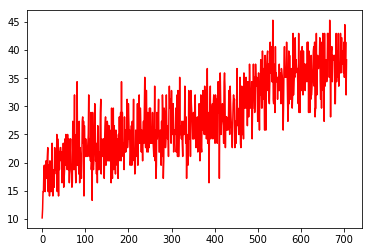

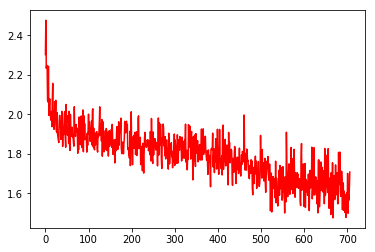

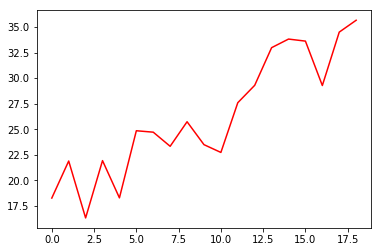

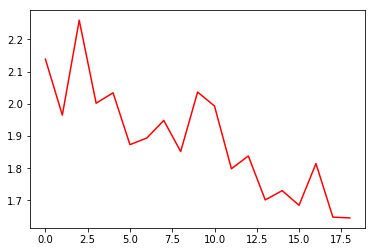

In [3]:
# 查看训练过程的信息
import  matplotlib.pyplot as plt

def parse(in_file,flag):
    num=-1
    ys=list()
    xs=list()
    losses=list()
    with open(in_file,"r") as reader:
        for aLine in reader:
            #print(aLine)

            res=[e for e in aLine.strip('\n').split(" ")]
            if res[0]=="Train" and flag=="Train":
                num=num+1
                ys.append(float(res[-1]))
                xs.append(int(num))
                losses.append(float(res[-3].split(',')[0]))
            if res[0]=="Validation" and flag=="Validation":
                num=num+1
                xs.append(int(num))
                tmp=[float(e) for e in res[-2].split('/')]
                ys.append(100*float(tmp[0]/tmp[1]))
                losses.append(float(res[-4].split(',')[0]))

    plt.figure(1)
    plt.plot(xs,ys,'r-')


    plt.figure(2)
    plt.plot(xs, losses, 'r-')
    plt.show()

def main():
    in_file="D://INFO.txt"
    # 显示训练阶段的正确率和Loss信息
    parse(in_file,"Train") # "Validation"
    # 显示验证阶段的正确率和Loss信息
    parse(in_file,"Validation") # "Validation"


if __name__=="__main__":
    main()